# Let's apply some transformations to our dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
bank_f = pd.read_csv('../Data/raw/bank-full.csv', sep = ';')
bank_f

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
#1. I make the split calling the function from function.py
#2. I upload the resulting df -> categorical_df, numericals_df
def num_cat_splitter(df):
    df1 = df.copy()
    numerical_df = df1.select_dtypes(np.number)
    categorical_df = df1.select_dtypes(object)
    return numerical_df, categorical_df

In [4]:
numerical_df, categorical_df = num_cat_splitter(bank_f)

As we saw in *exploratory_data_analysis.ipynb* our dataset had a lot of outliers:

In [5]:
def box_generator (df): #(df, save="Yes"):
    plt_size = len(df.columns)
    fig, ax = plt.subplots(plt_size, figsize=(16,16))
    n = 0
    for col in df.columns:
        sns.boxplot(data = df, x = col, ax = ax[n])
        n +=1
    plt.tight_layout()      
    plt.show()

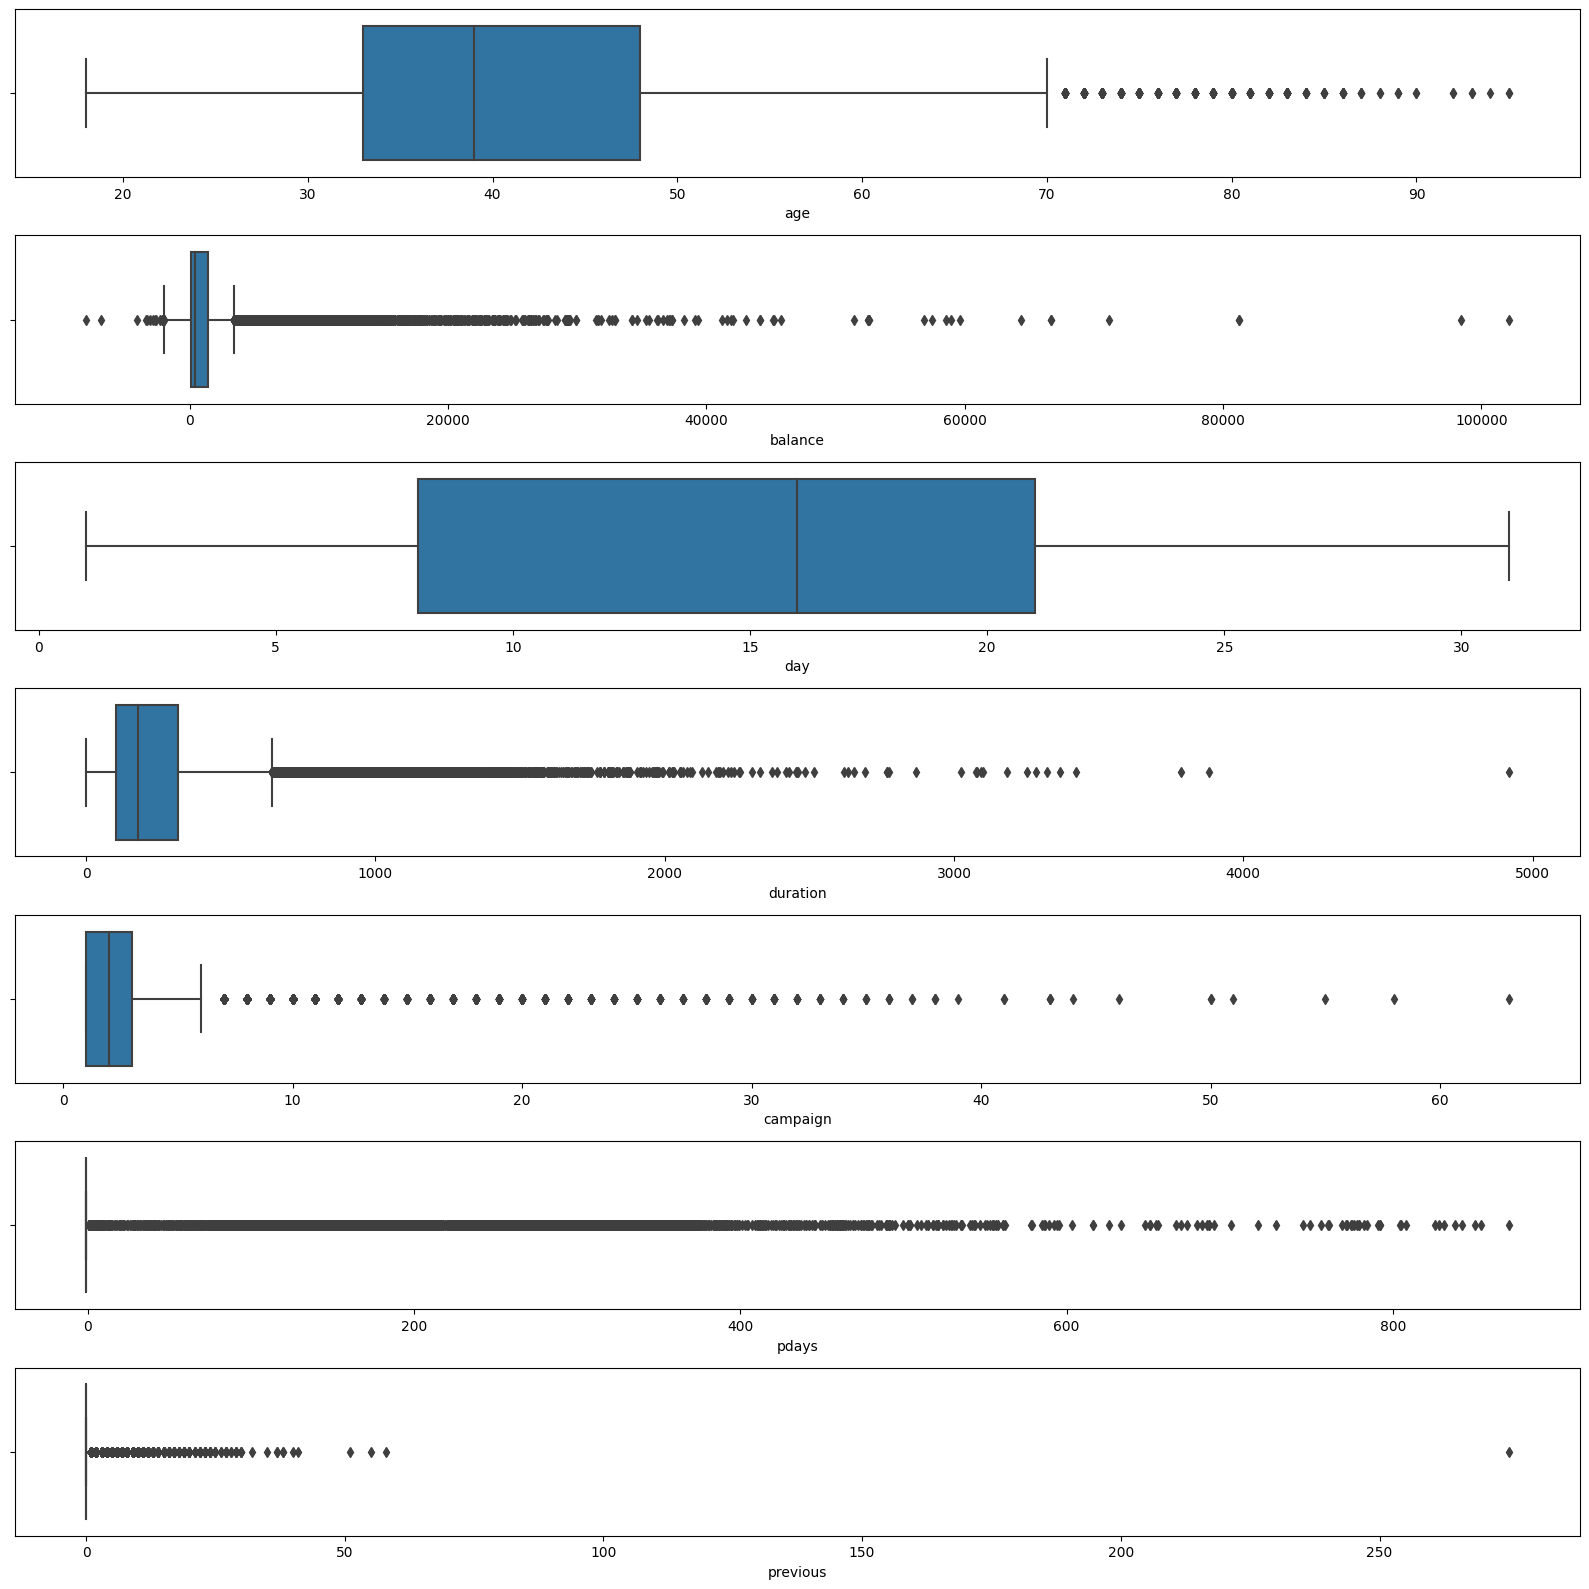

In [6]:
box_generator(numerical_df)

Therefore we are going to remove outliers taking into consideration all the values which are between 3 times smaller or bigger the standard deviation of the mean:

In [7]:
#%%writefile -a functions.py
def outlier_remover(df):
    df1 = df.copy()
    thr=3
    to_remove = []
    for col in df1.columns:
        sd_dw = np.mean(df1[col]) - (thr*(df1[col].std()))
        sd_up = np.mean(df1[col]) + (thr*(df1[col].std()))
        out = df1[(df1[col] < sd_dw)|(df1[col] > sd_up)]
        to_remove += list(out.index)
    df1 = df1.drop(to_remove)
    df1 = df1.reset_index(drop=True)
    return df1

In [8]:
numerical_0out = outlier_remover(numerical_df)

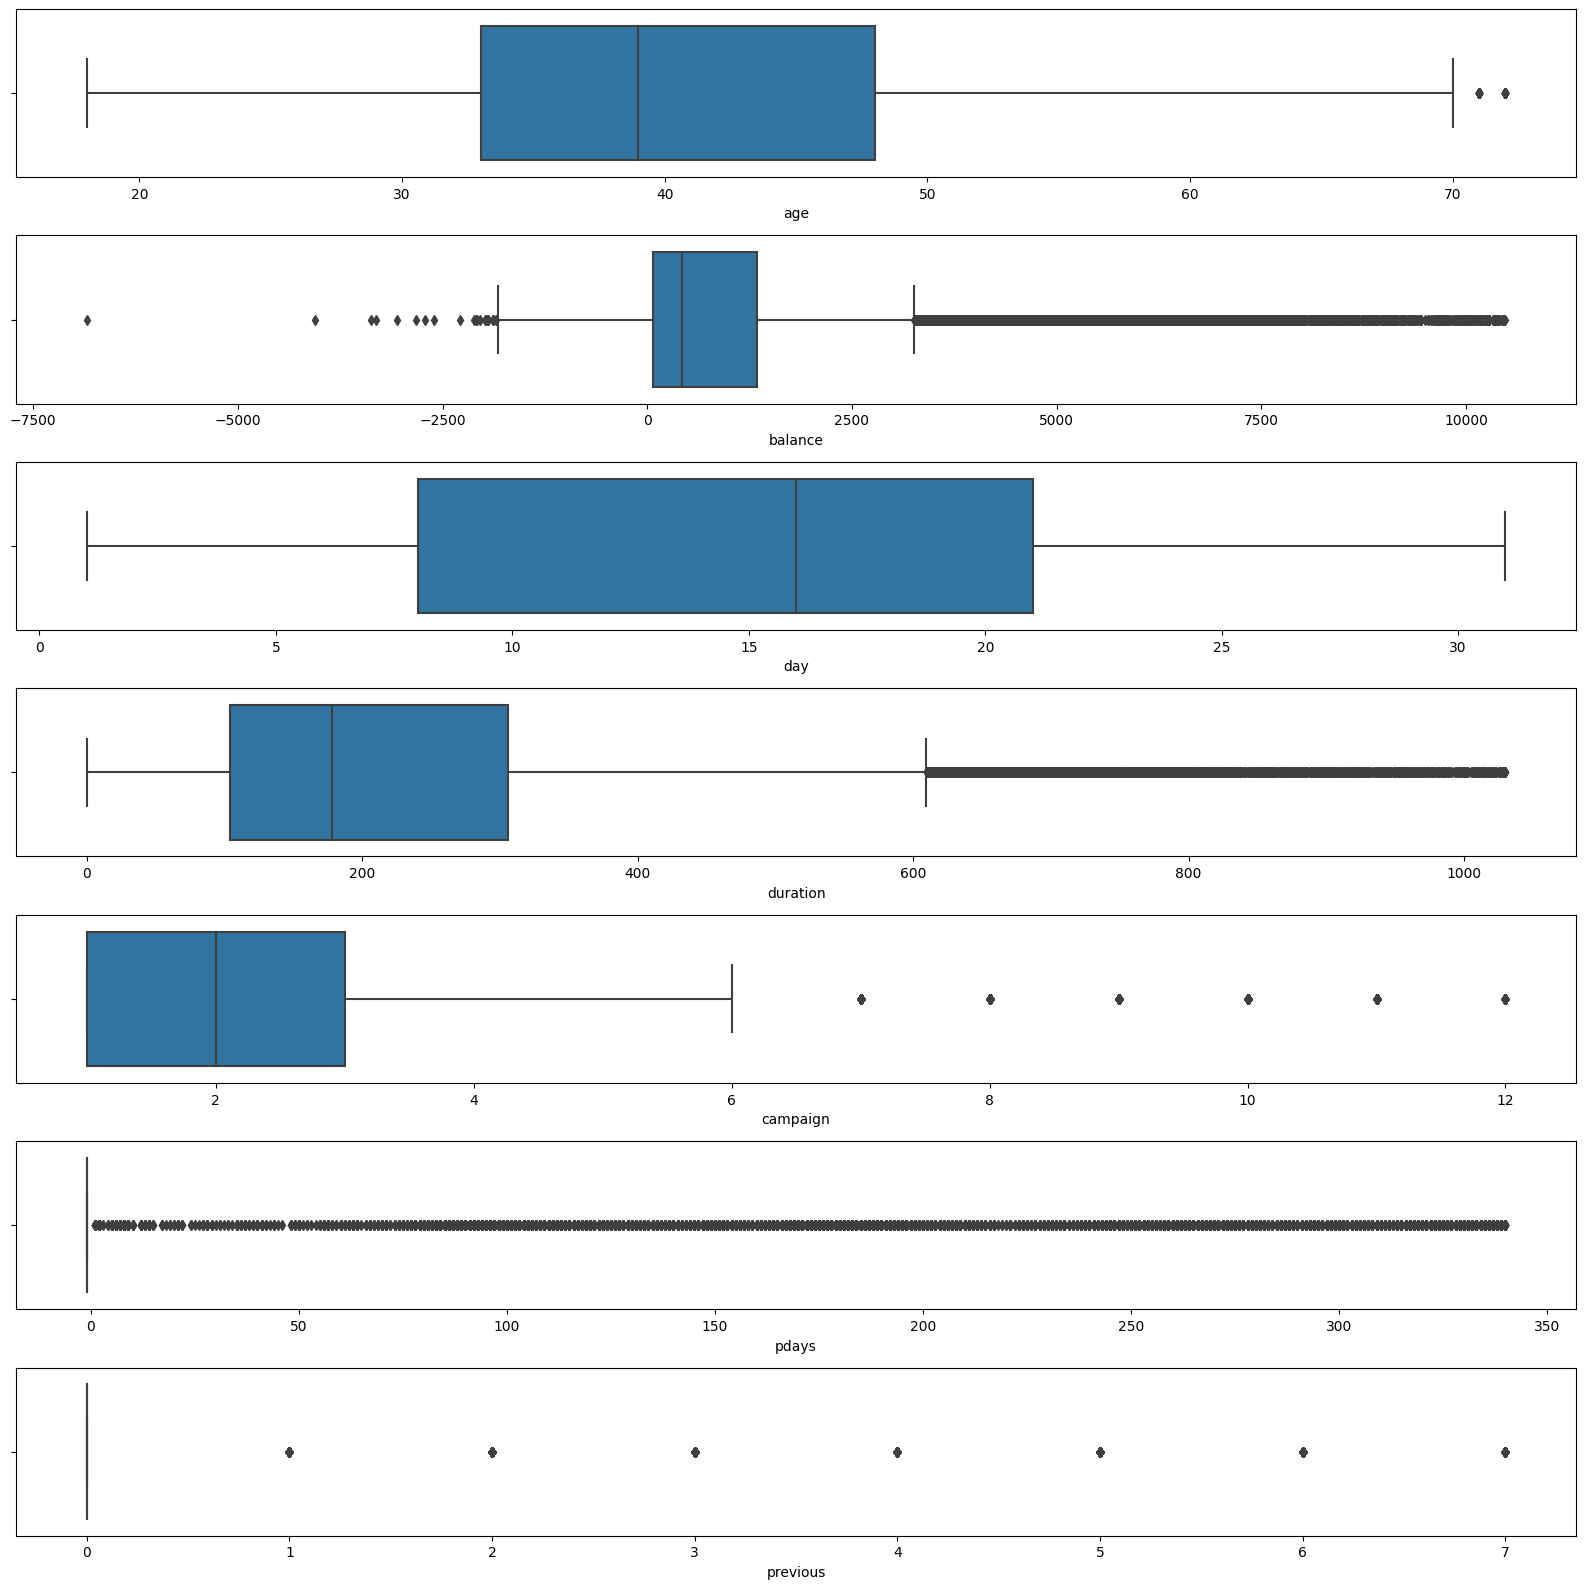

In [9]:
box_generator(numerical_0out)

Now our data looks much better, however, the numerical columns are heavily skewed:

In [10]:
def hist_generator(df):
    plt_size = len(df.columns)
    fig, ax = plt.subplots(plt_size, figsize=(12,20))
    n = 0
    for col in df.columns:
        sns.histplot(data = df, x = col, ax = ax[n])
        n +=1
    plt.tight_layout()      
    plt.show()

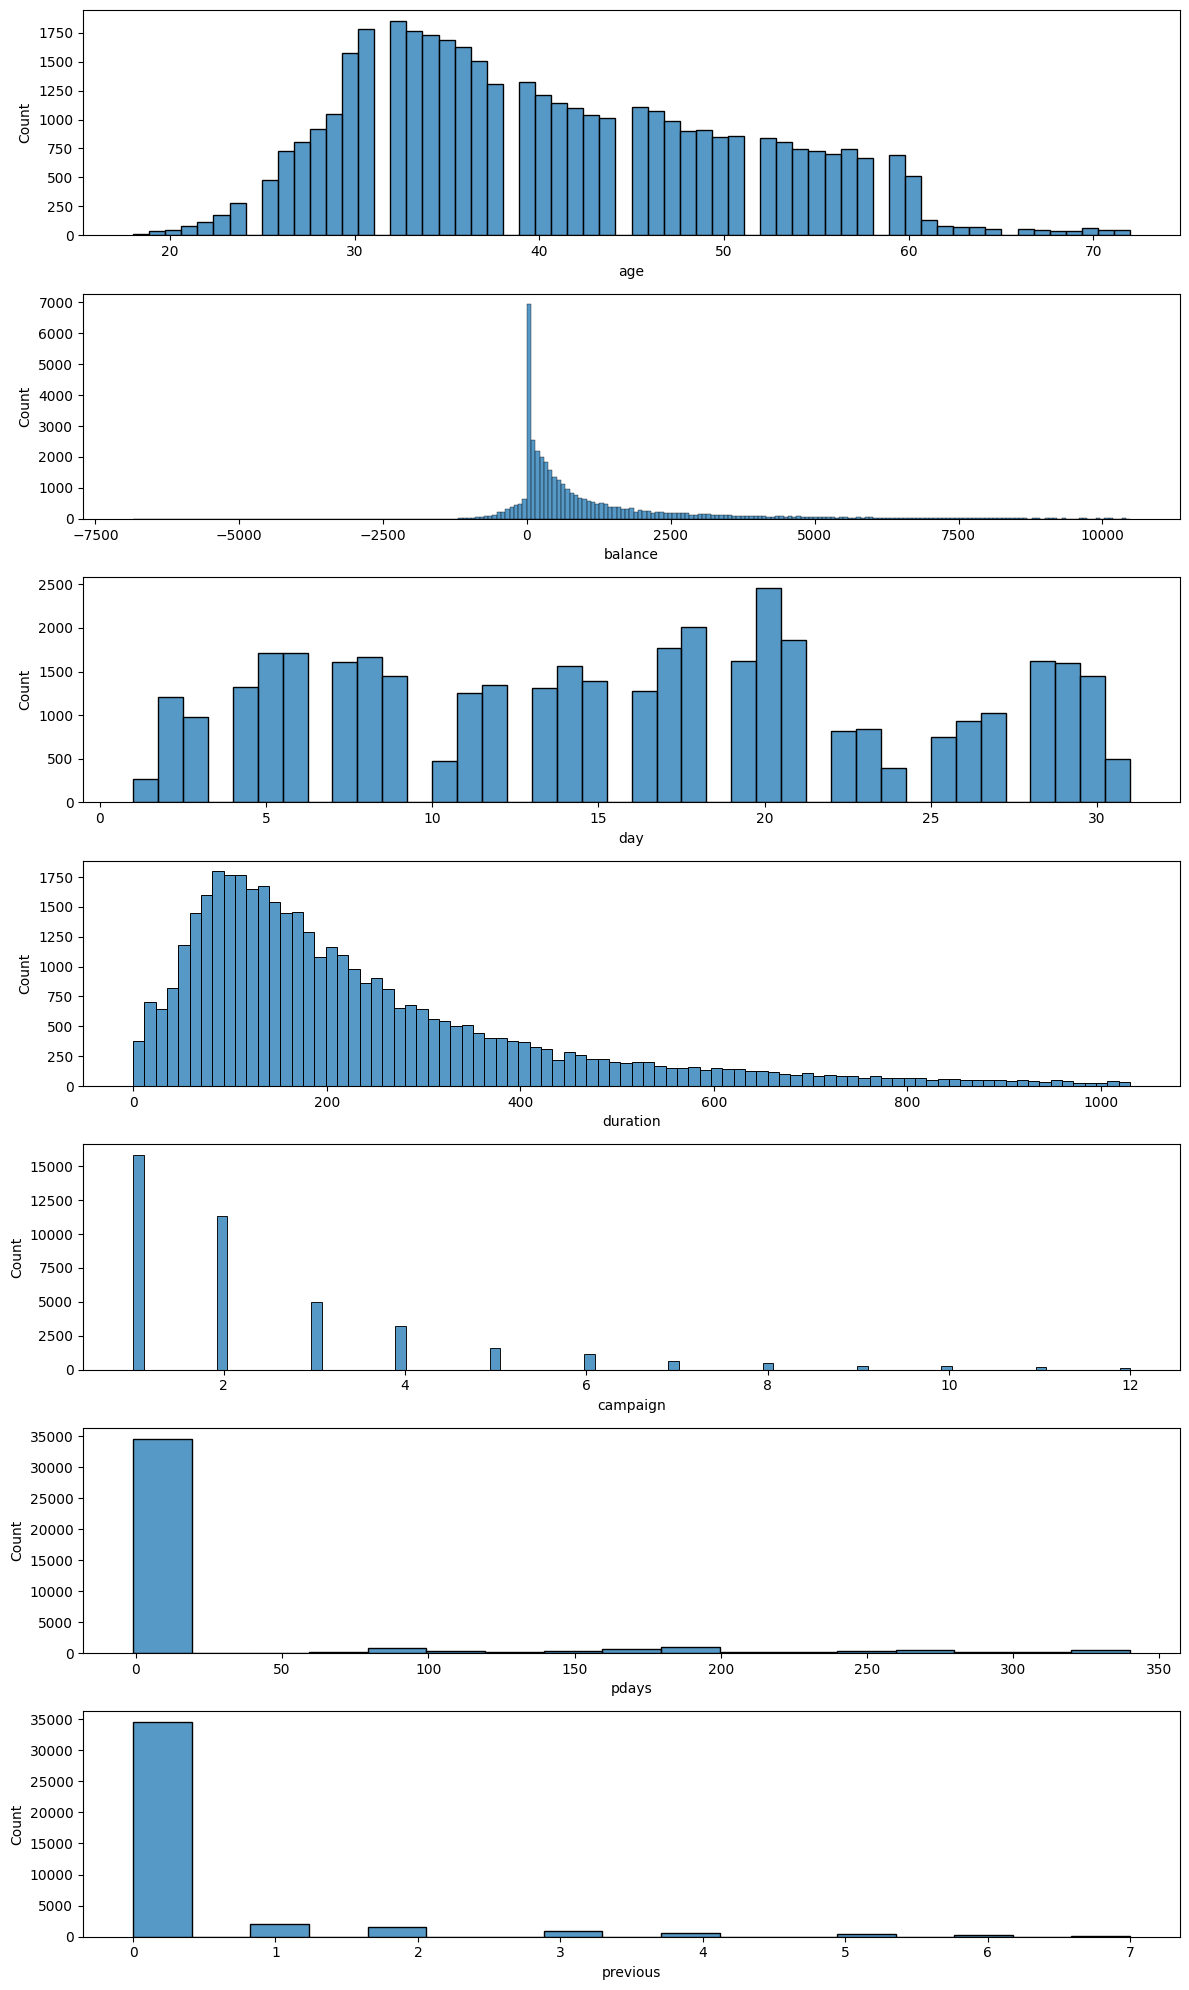

In [11]:
hist_generator(numerical_0out)

Some are better than before, nevertheless we can apply a PowerTransformer in order to make distributions more Gaussian-like:

In [ ]:
#should we do previously the X-Y split??

In [ ]:
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer().fit(numerical_0out)
num_tran = transformer.transform(numerical_0out)